## Solve Autoencoder and Eigenfunction of 2D systems. 
This notebook implements algorithms in the colvar-finder package, and can be run independently. 

In [1]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import math 
import torch.nn as nn
from sklearn.model_selection import train_test_split 
import random
import itertools 
from tqdm import tqdm
import os
import time
from tensorboardX import SummaryWriter
import cv2 as cv
from torch import nn, sin
from torch.nn import Parameter

###  defines all potentials classes

In [2]:
def g(a):
    """Gaussian function

    :param a: float, real value
    :return: float, g(a)
    """
    return np.exp(- a ** 2)

class MuellerPotential:
    def __init__(self, beta, *argv):
        self.beta = beta
        self.dim = 2
        self.a = [-1, -1, -6.5, 0.7]
        self.b = [0, 0, 11, 0.6]
        self.c = [-10, -10, -6.5, 0.7]
        self.A = [-200, -100, -170, 15]
        self.xc = [1, 0, -0.5, -1]
        self.yc = [0, 0.5, 1.5, 1]        

    def V(self, X):
        s = 0
        for j in range(4):
            dx = X[0] - self.xc[j]
            dy = X[1] - self.yc[j]
            s += self.A[j] * np.exp(self.a[j] * dx**2 + self.b[j] * dx * dy + self.c[j] * dy**2)
        return s
        
    def gradV(self, X):
        s = 0
        dVx = 0
        dVy = 0
        for j in range(4):
            dx = X[0] - self.xc[j]
            dy = X[1] - self.yc[j]            
            dVx += self.A[j] * (2 * self.a[j] * dx + self.b[j] * dy) \
                    * np.exp(self.a[j] * dx**2 + self.b[j] * dx * dy + self.c[j] * dy**2)
            dVy += self.A[j] * (self.b[j] * dx + 2 * self.c[j] * dy) \
                    * np.exp(self.a[j] * dx**2 + self.b[j] * dx * dy + self.c[j] * dy**2)
        
        return np.array((dVx, dVy))
    
class TripleWellPotential:
    def __init__(self, beta, *argv):
        self.beta = beta
        self.dim = 2
        
    def V(self, X):
        u = g(X[0]) * (g(X[1] - 1/3) - g(X[1] - 5/3))
        v = g(X[1]) * (g(X[0] - 1) + g(X[0] + 1))
        V = 3 * u - 5 * v + 0.2 * (X[0] ** 4) + 0.2 * ((X[1] - 1/3) ** 4)
        return V
        
    def gradV(self, X):
        u = g(X[0]) * (g(X[1] - 1/3) - g(X[1] - 5/3))
        a = g(X[1]) * ((X[0] - 1)*g(X[0] - 1) + (X[0] + 1) * g(X[0] + 1))
        dVx = -6 * X[0] * u + 10 * a + 0.8 * (X[0] ** 3)
        
        u = g(X[0]) * ((X[1] - 1/3) * g(X[1] - 1/3) - (X[1] - 5/3) * g(X[1] - 5/3))
        b = g(X[1]) * (g(X[0] - 1) + g(X[0] + 1)) 
        dVy = -6 * u + 10 * X[1] * b + 0.8 * ((X[1] - 1/3) ** 3)
        return np.array((dVx, dVy))
        
class TripleWellOneChannelPotential:
    def __init__(self, beta, *argv):
        self.beta = beta
        self.dim = 2
        
    def V(self, X):
        a = + 10 * np.exp(- 25 * X[0] ** 2 - (X[1] + (1 / 3)) ** 2)
        b = - 3 * np.exp(- X[0] ** 2 - (X[1] - (5 / 3)) ** 2)
        c = - 5 * np.exp(- X[1] ** 2 - (X[0] - 1) ** 2)
        d = - 5 * np.exp(- X[1] ** 2 - (X[0] + 1) ** 2) 
        e = + 0.2 * X[0] ** 4 + 0.2 * (X[1] - (1 / 3)) ** 4
        V = a + b + c + d + e 
        return V
      
    def gradV(self, X):
        x = X[0]
        y = X[1]
        a = - 20 * 25 * x * np.exp(- 25 * x ** 2 - (y + (1 / 3)) ** 2)
        b = + 6 * x * np.exp(- x ** 2 - (y - (5 / 3)) ** 2)
        c = + 10 * (x - 1) * np.exp(- y ** 2 - (x - 1) ** 2)
        d = + 10 * (x + 1) * np.exp(- y ** 2 - (x + 1) ** 2) 
        e = + 0.8 * x ** 3
        dVx = a + b + c + d + e
        
        a = - 20 * (y + (1 / 3)) * np.exp(- 25 * x ** 2 - (y + (1 / 3)) ** 2)
        b = + 6 * (y - (5 / 3)) * np.exp(- x ** 2 - (y - (5 / 3)) ** 2)
        c = + 10 * y * np.exp(- y ** 2 - (x - 1) ** 2)
        d = + 10 * y * np.exp(- y ** 2 - (x + 1) ** 2) 
        e = + 0.8 * y ** 3
        dVy = a + b + c + d + e     
        
        return np.array((dVx, dVy)) 
        
class DoubleWellPotential:
    def __init__(self, beta, *argv):
        self.beta = beta
        self.dim = 2
        
    def V(self, X):
        a = 3 * np.exp(- X[0] ** 2 - X[1] ** 2)
        b = - 5 * np.exp(- X[1] ** 2 - (X[0] - 1) ** 2)
        c = - 5 * np.exp(- X[1] ** 2 - (X[0] + 1) ** 2)
        d = + 0.2 * X[0] ** 4 + 0.2 * X[1] ** 4
        V = a + b + c + d
        return V
     
    def gradV(self, X):
        x = X[0]
        y = X[1]
        a = -6 * x * np.exp(- x ** 2 - y ** 2)
        b = + 10 * (x - 1) * np.exp(- y ** 2 - (x - 1) ** 2)
        d = + 10 * (x + 1) * np.exp(- y ** 2 - (x + 1) ** 2)
        c = + 0.8 * x ** 3
        dVx = a + b + c + d
   
        a = - 6 * y * np.exp(- x ** 2 - y ** 2) 
        b = + 10 * y * np.exp(- y ** 2 - (x - 1) ** 2)
        c = + 10 * y * np.exp(- y ** 2 - (x + 1) ** 2)
        d = + 0.8 * y ** 3
        dVy = a + b + c + d
        return np.array((dVx, dVy)) 
               
class TripleWellPotAlongCircle :
    def __init__(self, beta, eps):
        self.beta = beta
        self.eps = eps 
        self.dim = 2

    def V(self, x):
      # angle in [-pi, pi] 

      theta = np.arctan2(x[1], x[0])
      # radius
      r = np.sqrt( x[0] * x[0] + x[1] * x[1] )

      v_vec = np.zeros(len(x))
      for idx in range(len(x)) :
          # potential V_1
          if theta > math.pi / 3 : 
            v_vec = (1-(theta * 3 / math.pi- 1.0)**2)**2
          if theta < - math.pi / 3 : 
            v_vec = (1-(theta * 3 / math.pi + 1.0)**2)**2
          if theta > - math.pi / 3 and theta < math.pi / 3:
            v_vec = 3.0 / 5.0 - 2.0 / 5.0 * np.cos(3 * theta)  
      # potential V_2
      v_vec = v_vec * 1.0 + (r - 1)**2 * 1.0 / self.eps + 5.0 * np.exp(-5.0 * r**2) 
      return v_vec

    def gradV(self, x): 
      # angle
      theta = np.arctan2(x[1], x[0])
      # radius
      r = np.sqrt( x[0] * x[0] + x[1] * x[1] )

      if np.fabs(r) < 1e-8: 
          print ("warning: radius is too small! r=%.4e" % r)
      dv1_dangle = 0.0
      # derivative of V_1 w.r.t. angle
      if theta > math.pi / 3: 
        dv1_dangle = 12 / math.pi * (theta * 3 / math.pi - 1) * ((theta * 3 / math.pi- 1.0)**2-1)
      if theta < - math.pi / 3: 
        dv1_dangle = 12 / math.pi * (theta * 3 / math.pi + 1) * ((theta * 3 / math.pi + 1.0)**2-1)
      if theta > -math.pi / 3 and theta < math.pi / 3:
        dv1_dangle = 1.2 * math.sin (3 * theta)
      # derivative of V_2 w.r.t. angle
      dv2_dangle = 0
      # derivative of V_2 w.r.t. radius
      dv2_dr = 2.0 * (r-1.0) / self.eps - 50.0 * r * np.exp(-r**2/0.2)

      return np.array((-(dv1_dangle + dv2_dangle) * x[1] / (r * r)+ dv2_dr * x[0] / r,  (dv1_dangle + dv2_dangle) * x[0] / (r * r)+ dv2_dr * x[1] / r))

class StiffPot : 
    def __init__(self, beta, eps):
        self.beta = beta
        self.eps = eps 
        self.dim = 2

    def V(self, X):
      return (X[0]**2 - 1)**2 + 1.0 / self.eps * (X[0]**2 + X[1] - 1)**2

    def gradV(self, X): 
      return np.array(( 4.0 * X[0] * (X[0]**2 - 1.0 + 1.0 / self.eps * (X[0]**2 + X[1] - 1)), 2.0 / self.eps * (X[0]**2 + X[1] - 1)) )

class UniformPotAlongCircle :
    def __init__(self, beta, eps):
        self.beta = beta
        self.eps = eps 
        self.dim = 2

    def V(self, X):
      return 1.0 / self.eps * (X[0]**2 + X[1]**2 - 1)**2

    def gradV(self, X): 
      return np.array( (4.0 * X[0] / self.eps * (X[0]**2 + X[1]**2 - 1), 4.0 * X[1] / self.eps * (X[0]**2 + X[1]**2 - 1)) )

class DoubleWellPotAlongCircle :
    def __init__(self, beta, eps):
        self.beta = beta
        self.eps = eps 
        self.dim = 2

    def V(self, X):
        return 2.0 * X[1]**2 + 1.0 / self.eps * (X[0]**2 + X[1]**2 - 1)**2

    def gradV(self, X): 
        return np.array( (4.0 * X[0] / self.eps * (X[0]**2 + X[1]**2 - 1), 4.0 * X[1] + 4.0 * X[1] / self.eps * (X[0]**2 + X[1]**2 - 1)) )

### define parameters

In [8]:
def set_all_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
    random.seed(seed)
    
# x and y domains for each potential
x_domains = [[-1.5, 1.0], [-2.5, 2.5], [-2.5, 2.5], [-2.5, 2.5], [-3.5, 3.5], [-3.0, 3.0], [-2, 2], [-1.5, 1.5], [-1.5, 1.5] ]
y_domains = [[-0.5, 2.0], [-1.5, 2.5], [-1.5, 2.5], [-1.5, 2.5], [-3.5, 3.5], [-3.0, 3.0], [-1.8, 1.8], [-1.5, 1.5], [-1.5, 1.5] ]
x0_list = [[-0.6, 1.2], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1] ]
v_min_max = [[-120,50], [-4,3], [-4,3], [-4,7], [0.3,8], [0,10], [0,5], [0,5], [0,5] ]

# The names correspond to classes above.
pot_list = [ MuellerPotential, TripleWellPotential, TripleWellOneChannelPotential, DoubleWellPotential, \
        TripleWellPotAlongCircle, StiffPot, UniformPotAlongCircle, DoubleWellPotAlongCircle ] 

# proper beta for each potential
beta_list = [0.07, 2.5, 1.0, 1.0, 2.0, 1.0, 1.0, 2.5]
delta_t_list = [0.0002, 0.001, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
density_max_list = [0.4, 0.4, 0.4, 0.4, 0.25, 0.25, 0.25, 0.25]

# choose a potential in the pot_list above
pot_id = 0
seed = 30
eps = 0.5
beta = beta_list[pot_id]
delta_t = delta_t_list[pot_id]
density_max = density_max_list[pot_id]

pot = pot_list[pot_id](beta, eps)
pot_name = type(pot).__name__

print ('potential name: %s' % pot_name) 

x_domain = x_domains[pot_id] 
y_domain = y_domains[pot_id] 

# for data generation
N = 100000
save = 10
        
set_all_seeds(seed)


potential name: MuellerPotential


### visualise the potential

min and max values of potential: (-146.6372, 1649.1506)
(100, 150) (100, 150) (100, 150)


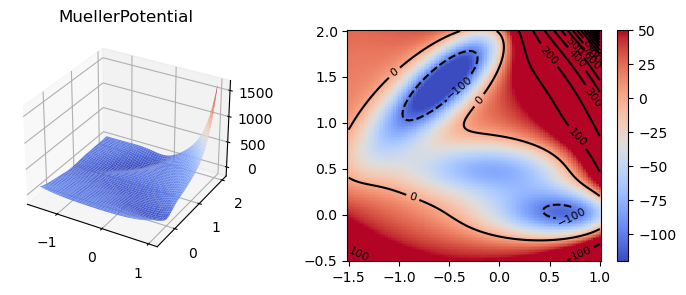

In [6]:
nx = 100
ny = 150
dx = (x_domain[1] - x_domain[0]) / nx
dy = (y_domain[1] - y_domain[0]) / ny

gridx = np.linspace(x_domain[0], x_domain[1], nx)
gridy = np.linspace(y_domain[0], y_domain[1], ny)
x_plot = np.outer(gridx, np.ones(ny)) 
y_plot = np.outer(gridy, np.ones(nx)).T 

x2d = np.concatenate((x_plot.reshape(nx * ny, 1), y_plot.reshape(nx * ny, 1)), axis=1)

pot_on_grid = np.array([pot.V(x) for x in x2d]).reshape(nx, ny)
print ( "min and max values of potential: (%.4f, %.4f)" % (pot_on_grid.min(), pot_on_grid.max()) )

fig = plt.figure(figsize=(9,3))
ax0 = fig.add_subplot(1, 2, 1, projection='3d')
ax1 = fig.add_subplot(1, 2, 2)
ax0.set_title(pot_name)
print (x_plot.shape, y_plot.shape, pot_on_grid.shape)

ax0.plot_surface(x_plot, y_plot, pot_on_grid, cmap='coolwarm', edgecolor='none')
im = ax1.pcolormesh(x_plot, y_plot, pot_on_grid, cmap='coolwarm',shading='auto', vmin=v_min_max[pot_id][0], vmax=v_min_max[pot_id][1])
contours = ax1.contour(x_plot, y_plot, pot_on_grid, 20, colors='black')
ax1.clabel(contours, inline=True, fontsize=8)
fig.colorbar(im, ax=ax1)



### generate a trajectory according an Euler--Maruyama discretization 
$$
X^{n+1} = X^n - \Delta t \nabla V(X^n) + \sqrt{\frac{2 \Delta t}{\beta}} \, G^n 
$$

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 45107.33it/s]


(-0.5, 2.0)

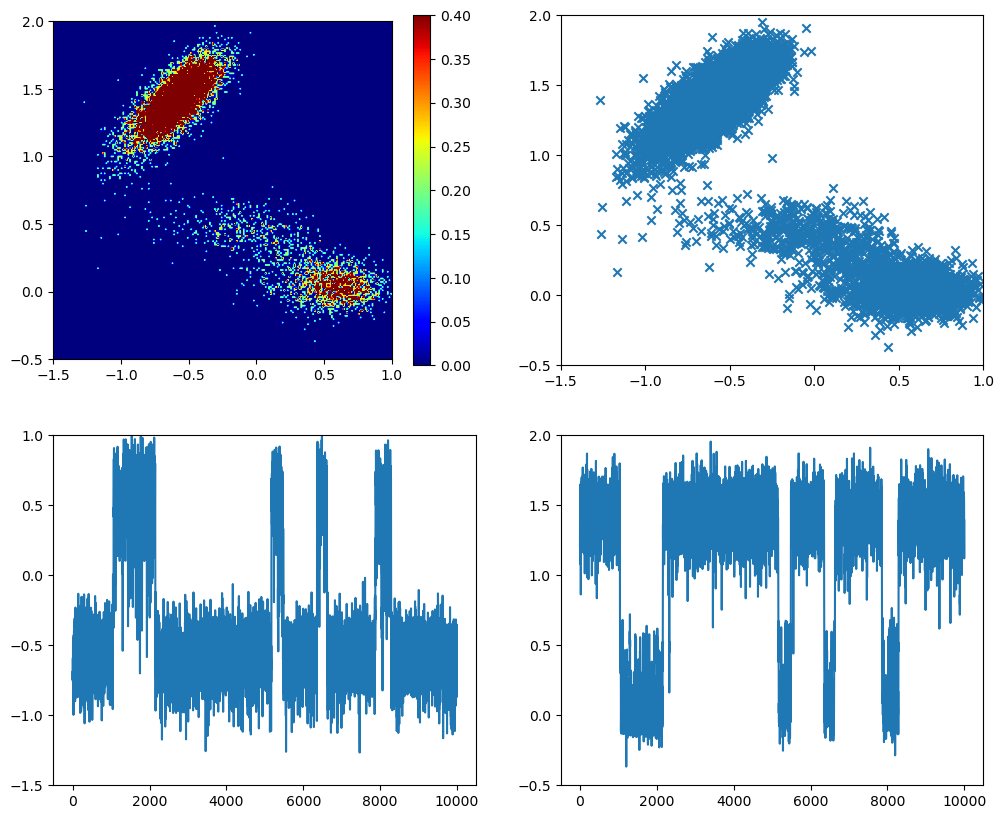

In [9]:
def UnbiasedTraj(pot, X_0, delta_t=1e-3, N=1000, save=1, save_energy=False, seed=0):
    """Simulates an overdamped langevin trajectory with a Euler-Maruyama numerical scheme 

    :param pot: potential object, must have methods for energy gradient and energy evaluation
    :param X_0: Initial position, must be a 2D vector
    :param delta_t: Discretization time step
    :param N: Number of points in the trajectory (the total simulation time is therefore N * delta_t)
    :param save: Integer giving the period (counted in number of steps) at which the trajectory is saved
    :param save_energy: Boolean parameter to save energy along the trajectory

    :return: traj: np.array with ndim = 2 and shape = (N // save + 1, 2)
    :return: Pot_values: np.array with ndim = 2 and shape = (N // save + 1, 1)
    """
    r = np.random.RandomState(seed)
    X = X_0.reshape(2)
    dim = X.shape[0]
    traj = [X]
    if save_energy:
        Pot_values = [pot.V(X)]
    else:
        Pot_values = None
    for i in tqdm(range(N)):
        b = r.normal(size=(dim,))
        X = X - pot.gradV(X) * delta_t + np.sqrt(2 * delta_t/pot.beta) * b
        if i % save==0:
            traj.append(X)
            if save_energy:
                Pot_values.append(pot.V(X)[0])
    return np.array(traj), np.array(Pot_values)


x_0 = np.array(x0_list[pot_id])

### Generate the trajectory
trajectory, _ = UnbiasedTraj(pot, x_0, delta_t=delta_t, N=N, save=save, save_energy=False, seed=seed)

### Plot the trajectory 
fig = plt.figure(figsize=(12,10))
ax0 = fig.add_subplot(2, 2, 1)
ax1 = fig.add_subplot(2, 2, 2)
ax2 = fig.add_subplot(2, 2, 3)
ax3 = fig.add_subplot(2, 2, 4)

nx = ny = 200
h = np.histogram2d(trajectory[:,0], trajectory[:,1], bins=[nx, ny], range=[[x_domain[0],x_domain[1]],[y_domain[0],y_domain[1]]])[0]
s = sum(sum(h))
im = ax0.imshow(h.T / (s * dx * dy), origin = "lower", \
                extent=[x_domain[0],x_domain[1],y_domain[0], y_domain[1]], \
                cmap=cm.jet, vmin=0.0, vmax=density_max)
fig.colorbar(im, ax=ax0)
ax0.set_xlim([x_domain[0], x_domain[1]])
ax0.set_ylim([y_domain[0], y_domain[1]])

#fig.colorbar(im, cax=cax, cmap=cm.jet)
#ax0.pcolormesh(x_plot, y_plot, pot_on_grid, cmap='coolwarm_r', shading='auto')
ax1.scatter(trajectory[:,0], trajectory[:,1], marker='x')
#ax1.plot(range(len(trajectory[:,0])), trajectory[:,0], label='x coodinate along trajectory')
ax1.set_xlim([x_domain[0], x_domain[1]])
ax1.set_ylim([y_domain[0], y_domain[1]])

#ax2.plot()
ax2.plot(range(len(trajectory[:,0])), trajectory[:,0], label='x coodinate along trajectory')
ax2.set_ylim([x_domain[0], x_domain[1]])

ax3.plot(range(len(trajectory[:,1])), trajectory[:,1], label='y coodinate along trajectory')
ax3.set_ylim([y_domain[0], y_domain[1]])

In [10]:
def create_sequential_nn(layer_dims, activation=torch.nn.Tanh()):
    layers = []
    for i in range(len(layer_dims)-2) :
        layers.append(torch.nn.Linear(layer_dims[i], layer_dims[i+1])) 
        layers.append(activation)
    layers.append(torch.nn.Linear(layer_dims[-2], layer_dims[-1])) 
    return torch.nn.Sequential(*layers)

### define two training tasks 

#### task 1: train autoencoder  

In [16]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, e_layer_dims, d_layer_dims, activation=torch.nn.Tanh()):
        super(AutoEncoder, self).__init__()
        self.encoder = create_sequential_nn(e_layer_dims, activation)
        self.decoder = create_sequential_nn(d_layer_dims, activation)
    def forward(self, inp):
        return self.decoder(self.encoder(inp))

class AutoEncoderTask(object):
    def __init__(self, args, trajectory, model_path):
        self.learning_rate = args.learning_rate
        self.num_epochs= args.num_epochs
        self.batch_size = args.batch_size 
        self.test_ratio = args.test_ratio
        self.k = args.k
        self.model_path = model_path
        self.writer = SummaryWriter(model_path)
        self.alpha = args.alpha
        
        #--- prepare the data ---
        self.traj = torch.from_numpy(trajectory).float()
        self.weights = torch.ones(self.traj.shape[0])

        # print information of trajectory
        print ( '\nshape of trajectory data array:\n {}'.format(self.traj.shape) )

        self.input_dim = self.traj.shape[1]  

        # output dimension of the map 
        e_layer_dims = [self.input_dim] + args.e_layer_dims + [self.k]
        d_layer_dims = [self.k] + args.d_layer_dims + [self.input_dim]
        
        self.model = AutoEncoder(e_layer_dims, d_layer_dims, args.activation())
        # print the model
        print ('\nAutoencoder: input dim: {}, encoded dim: {}\n'.format(self.input_dim, self.k), self.model)

        print (f'Training result will be saved in: {model_path}.\nView it in tensorboard!\n')
        
        if args.optimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        else:
            self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.learning_rate)

    def colvar_model(self):
        return self.model.encoder
    
    def weighted_MSE_loss(self, X, weight):
        # Forward pass to get output
        out = self.model(X)
        # Evaluate loss
        return (weight * torch.sum((out-X)**2, dim=1)).sum() / weight.sum()
    
    def gradient_regularizer(self, X, weight):
        # Forward pass to get output
        y = self.model(X)

        """
          Compute spatial gradients.
          The flag create_graph=True is needed, because later we need to compute
          gradients w.r.t. parameters; Please refer to the torch.autograd.grad function for details.
        """
        y_grad_vec = [torch.autograd.grad(outputs=y[:,idx].sum(), inputs=X, retain_graph=True, create_graph=True)[0] for idx in range(self.k)]

        y_grad_vec = [y_grad.reshape((-1, self.input_dim)) for y_grad in y_grad_vec]
        tot_weight = weight.sum()
        # Mean and variance evaluated on data
        mean_list = [(y[:,idx] * weight).sum() / tot_weight for idx in range(self.k)]
        var_list = [(y[:,idx]**2 * weight).sum() / tot_weight - mean_list[idx]**2 for idx in range(self.k)]

        grad_reg_loss = 1.0 / tot_weight * sum([torch.sum((y_grad_vec[idx]**2).sum(dim=1) * weight) / var_list[idx] for idx in range(self.k)])
        return grad_reg_loss

    def plot_encoder(self, epoch):
        gridx = np.linspace(x_domain[0], x_domain[1], 100)
        gridy = np.linspace(y_domain[0], y_domain[1], 100)
        x_plot = np.outer(gridx, np.ones(100)) 
        y_plot = np.outer(gridy, np.ones(100)).T 

        x2d = torch.from_numpy(np.concatenate((x_plot.reshape(100 * 100, 1), y_plot.reshape(100 * 100, 1)), axis=1)).float()
        encoder_on_grid = self.model.encoder(x2d).detach().numpy()
        
        for idx in range(self.k):
            encoder = encoder_on_grid[:,idx].reshape(100,100)
            #print ( "min and max values of %dth dimension of encoder: (%.4f, %.4f)" % (idx, encoder.min(), encoder.max()) )

            fig = plt.figure(figsize=(10,5))
            ax0 = fig.add_subplot(1, 2, 1, projection='3d')
            ax1 = fig.add_subplot(1, 2, 2)  
            ax0.plot_surface(x_plot, y_plot, encoder, cmap='coolwarm', edgecolor='none')
            im = ax1.pcolormesh(x_plot, y_plot, encoder, cmap='coolwarm',shading='auto')
            contours = ax1.contour(x_plot, y_plot, encoder, 20, colors='black')
            ax1.clabel(contours, inline=True, fontsize=8)
            fig.colorbar(im, ax=ax1)
            fig_name = f"{self.model_path}/encoder_{idx}_{epoch}.jpg"
            fig.savefig(fig_name)
            #print ( "encoder profiles saved to file: %s" % fig_name )
            plt.close()
            self.writer.add_image(f'{idx}th dimension of encoder', cv.cvtColor(cv.imread(fig_name), cv.COLOR_BGR2RGB), global_step=epoch, dataformats='HWC')
    
    # the training function  
    def train(self):
        """Function to train the model
        """
        # split the dataset into a training set (and its associated weights) and a test set
        X_train, X_test, w_train, w_test, index_train, index_test = train_test_split(self.traj, self.weights, torch.arange(self.traj.shape[0], dtype=torch.long), test_size=self.test_ratio)  

        # method to construct data batches and iterate over them
        train_loader = torch.utils.data.DataLoader(dataset = torch.utils.data.TensorDataset(X_train, w_train, index_train),
                                                   batch_size=self.batch_size,
                                                   drop_last=True,
                                                   shuffle=False)
        test_loader  = torch.utils.data.DataLoader(dataset= torch.utils.data.TensorDataset(X_test, w_test, index_test),
                                                   batch_size=self.batch_size,
                                                   drop_last=True,
                                                   shuffle=False)
        
        # --- start the training over the required number of epochs ---
        self.loss_list = []
        
        print ("\ntraining starts, %d epochs in total." % self.num_epochs) 
        print ("%d iterations per epoch, %d iterations in total." % (len(train_loader), len(train_loader) * self.num_epochs))
        
        for epoch in tqdm(range(self.num_epochs)):
            # Train the model by going through the whole dataset
            self.model.train()
            train_loss = []
            for iteration, [X, weight, index] in enumerate(train_loader):
                X.requires_grad_()                
                # Clear gradients w.r.t. parameters
                self.optimizer.zero_grad()
                # Evaluate loss
                loss = self.weighted_MSE_loss(X, weight) + self.alpha * self.gradient_regularizer(X, weight)
                # Get gradient with respect to parameters of the model
                loss.backward()
                # Store loss
                train_loss.append(loss)
                # Updating parameters
                self.optimizer.step()
            # Evaluate the test loss on the test dataset
            self.model.eval()
            with torch.no_grad():
                # Evaluation of test loss
                test_loss = []
                for iteration, [X, weight, index] in enumerate(test_loader):
                    loss = self.weighted_MSE_loss(X, weight)
                    # Store loss
                    test_loss.append(loss)
                self.loss_list.append([torch.tensor(train_loss), torch.tensor(test_loss)])
                
            self.writer.add_scalar('Loss/train', torch.mean(torch.tensor(train_loss)), epoch)
            self.writer.add_scalar('Loss/test', torch.mean(torch.tensor(test_loss)), epoch)

            self.plot_encoder(epoch)

        print ("training ends.\n") 

### task 2: train eigenfunction 

In [17]:

class EigenFunction(nn.Module):
    def __init__(self, layer_dims, k, activation=torch.nn.Tanh()):
        super(EigenFunction, self).__init__()       
        assert layer_dims[-1] == 1, "each eigenfunction must be one-dimensional"
        self.eigen_funcs = torch.nn.ModuleList([create_sequential_nn(layer_dims, activation) for idx in range(k)])

    def forward(self, inp):
        return torch.cat([nn(inp) for nn in self.eigen_funcs], dim=1)

class EigenFunctionTask(object):
    def __init__(self, args, trajectory, model_path):
        self.learning_rate = args.learning_rate
        self.num_epochs= args.num_epochs
        self.batch_size = args.batch_size 
        self.test_ratio = args.test_ratio
        self.k = args.k
        self.model_path = model_path
        self.writer = SummaryWriter(model_path)
        
        self.alpha = args.alpha
        self.beta = beta
        self.sort_eigvals_in_training = args.sort_eigvals_in_training
        self.eig_w = args.eig_w

        # list of (i,j) pairs in the penalty term
        #self.ij_list = list(itertools.combinations_with_replacement(range(Param.k), 2))
        self.ij_list = list(itertools.combinations(range(self.k), 2))
        self.num_ij_pairs = len(self.ij_list)

        #--- prepare the data ---
        self.traj = torch.from_numpy(trajectory).float()
        # we will compute spatial gradients
        self.traj.requires_grad_()
        self.weights = torch.ones(self.traj.shape[0])

        # print information of trajectory
        print ( '\nshape of trajectory data array:\n {}'.format(self.traj.shape) )

        self.input_dim = self.traj.shape[1]  
        # diagnoal matrix 
        # the unit of eigenvalues given by Rayleigh quotients is ns^{-1}.
        self.diag_coeff = torch.ones(self.input_dim)

        # output dimension of the map 
        layer_dims = [self.input_dim] + args.layer_dims + [1]
        self.model = EigenFunction(layer_dims, self.k, args.activation())

        print ('\nEigenfunctions:\n', self.model)

        print (f'Training result will be saved in: {model_path}.\nView it in tensorboard!\n')

        if args.optimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        else:
            self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.learning_rate)

    def colvar_model(self):
        return self.model
       
    def loss_func(self, X, weight):
        # Evaluate function value on data
        y = self.model(X)

        """
          Compute spatial gradients.
          The flag create_graph=True is needed, because later we need to compute
          gradients w.r.t. parameters; Please refer to the torch.autograd.grad function for details.
        """
        y_grad_vec = [torch.autograd.grad(outputs=y[:,idx].sum(), inputs=X, retain_graph=True, create_graph=True)[0] for idx in range(self.k)]

        y_grad_vec = [y_grad.reshape((-1, self.input_dim)) for y_grad in y_grad_vec]

        # Total weight, will be used for normalization 
        tot_weight = weight.sum()

        # Mean and variance evaluated on data
        mean_list = [(y[:,idx] * weight).sum() / tot_weight for idx in range(self.k)]
        var_list = [(y[:,idx]**2 * weight).sum() / tot_weight - mean_list[idx]**2 for idx in range(self.k)]

        # Compute Rayleigh quotients as eigenvalues
        eig_vals = torch.tensor([1.0 / (tot_weight * self.beta) * torch.sum((y_grad_vec[idx]**2 * self.diag_coeff).sum(dim=1) * weight) / var_list[idx] for idx in range(self.k)])

        cvec = range(self.k)
        if self.sort_eigvals_in_training :
            cvec = np.argsort(eig_vals)
            # Sort the eigenvalues 
            eig_vals = eig_vals[cvec]

        non_penalty_loss = 1.0 / (tot_weight * self.beta) * sum([self.eig_w[idx] * torch.sum((y_grad_vec[cvec[idx]]**2 * self.diag_coeff).sum(dim=1) * weight) / var_list[cvec[idx]] for idx in range(self.k)])

        penalty = torch.zeros(1, requires_grad=True)

        # Sum of squares of variance for each eigenfunction
        penalty = sum([(var_list[idx] - 1.0)**2 for idx in range(self.k)])

        for idx in range(self.num_ij_pairs):
          ij = self.ij_list[idx]
          # Sum of squares of covariance between two different eigenfunctions
          penalty += ((y[:, ij[0]] * y[:, ij[1]] * weight).sum() / tot_weight - mean_list[ij[0]] * mean_list[ij[1]])**2

        loss = 1.0 * non_penalty_loss + self.alpha * penalty 
        
        return loss, eig_vals, non_penalty_loss, penalty, cvec
    
    def plot_eigenfunc(self, epoch, cvec):
        gridx = np.linspace(x_domain[0], x_domain[1], 100)
        gridy = np.linspace(y_domain[0], y_domain[1], 100)
        x_plot = np.outer(gridx, np.ones(100)) 
        y_plot = np.outer(gridy, np.ones(100)).T 

        x2d = torch.from_numpy(np.concatenate((x_plot.reshape(100 * 100, 1), y_plot.reshape(100 * 100, 1)), axis=1)).float()
        eigenfuncs_on_grid = self.model(x2d).detach().numpy()
        
        for idx in range(self.k):
            eigenfunc = eigenfuncs_on_grid[:,cvec[idx]].reshape(100,100)
            #print ( "min and max values of %dth eigenfunc: (%.4f, %.4f)" % (idx, eigenfunc.min(), eigenfunc.max()) )

            fig = plt.figure(figsize=(10,5))
            ax0 = fig.add_subplot(1, 2, 1, projection='3d')
            ax1 = fig.add_subplot(1, 2, 2)            
            ax0.plot_surface(x_plot, y_plot, eigenfunc, cmap='coolwarm', edgecolor='none')
            im=ax1.pcolormesh(x_plot, y_plot, eigenfunc, cmap='coolwarm',shading='auto')
            contours = ax1.contour(x_plot, y_plot, eigenfunc, 20, colors='black')
            ax1.clabel(contours, inline=True, fontsize=8)
            fig.colorbar(im, ax=ax1)

            fig_name = f"{self.model_path}/eigenfunc_{idx}_{epoch}.jpg"
            fig.savefig(fig_name)
            #print ( "%d eigenfunction profile saved to file: %s" % (idx, fig_name) )
            plt.close()
            self.writer.add_image(f'{idx}th eigenfunction', cv.cvtColor(cv.imread(fig_name), cv.COLOR_BGR2RGB), global_step=epoch, dataformats='HWC')

    def train(self):
        """Function to train the model
        """
        # split the dataset into a training set (and its associated weights) and a test set
        X_train, X_test, w_train, w_test, index_train, index_test = train_test_split(self.traj, self.weights, torch.arange(self.traj.shape[0], dtype=torch.long), test_size=self.test_ratio)  

        print (X_test.shape)
        # method to construct data batches and iterate over them
        train_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(X_train, w_train, index_train),
                                                   batch_size=self.batch_size,
                                                   drop_last=True,
                                                   shuffle=False)
        test_loader  = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(X_test, w_test, index_test),
                                                   batch_size=self.batch_size,
                                                   drop_last=True,
                                                   shuffle=False)
        
        # --- start the training over the required number of epochs ---
        self.loss_list = []
        
        print ("\ntraining starts, %d epochs in total." % self.num_epochs) 
        print ("Train set:\n\t%d data, %d iterations per epoch, %d iterations in total." 
               % (self.batch_size * len(train_loader), len(train_loader), len(train_loader) * self.num_epochs))
        print ("Test set:\n\t%d data, %d iterations per epoch, %d iterations in total." 
               % (self.batch_size * len(test_loader), len(test_loader), len(test_loader) * self.num_epochs))
        
        for epoch in tqdm(range(self.num_epochs)):
            # Train the model by going through the whole dataset
            self.model.train()
            train_loss = []
            for iteration, [X, weight, index] in enumerate(train_loader):
                X.requires_grad_()
                # Clear gradients w.r.t. parameters
                self.optimizer.zero_grad()
                # Evaluate loss
                loss, eig_vals, non_penalty_loss, penalty, cvec = self.loss_func(X, weight)
                # Get gradient with respect to parameters of the model
                loss.backward(retain_graph=True)
                # Store loss
                train_loss.append(loss)
                # Updating parameters
                self.optimizer.step()
            # Evaluate the test loss on the test dataset
            #self.model.eval()
            #with torch.no_grad():
                # Evaluation of test loss
            test_loss = []
            test_eig_vals = []
            test_penalty = []
            for iteration, [X, weight, index] in enumerate(test_loader):
                X.requires_grad_()
                loss, eig_vals, non_penalty_loss, penalty, cvec = self.loss_func(X, weight)
                    # Store loss
                test_loss.append(loss)
                test_eig_vals.append(eig_vals)
                test_penalty.append(penalty)

            self.loss_list.append([torch.tensor(train_loss), torch.tensor(test_loss)])
                
            self.writer.add_scalar('Loss/train', torch.mean(torch.tensor(train_loss)), epoch)
            self.writer.add_scalar('Loss/test', torch.mean(torch.tensor(test_loss)), epoch)
            self.writer.add_scalar('penalty', torch.mean(torch.tensor(test_penalty)), epoch)

            for idx in range(self.k):
                self.writer.add_scalar(f'{idx}th eigenvalue', torch.mean(torch.stack(test_eig_vals)[:,idx]), epoch)

            self.plot_eigenfunc(epoch, cvec)

        print ("training ends.\n") 


### define parameters

In [18]:
class MyArgs(object):

    def __init__(self, pot_name, train_autoencoder=True):

        #set training parameters
        self.use_gpu = False
        self.batch_size = 1000
        self.num_epochs = 200
        self.test_ratio = 0.2
        self.learning_rate = 0.005 
        self.optimizer = 'Adam' # 'SGD'
        self.pot_name = pot_name

        self.k = 1 # dimension of autoencoder, or number of eigenfunctions
        self.activation_name = 'Tanh'  
        if train_autoencoder :
            self.e_layer_dims = [20, 20, 20] 
            self.d_layer_dims = [20, 20] 
            self.alpha = 0.0            
        else :
            self.layer_dims = [20, 20, 20] 
            self.alpha = 20.0 
            self.eig_w = [1.0, 0.8, 0.6] 
            self.diffusion_coeff = 1e-5 
            self.sort_eigvals_in_training = True 

        self.activation = getattr(torch.nn, self.activation_name) 

        # CUDA support
        if torch.cuda.is_available() and self.use_gpu:
            self.device = torch.device('cuda')
        else:
            self.device = torch.device('cpu')

## plot colvar

In [19]:
def plot_cv(cv_model):
    gridx = np.linspace(x_domain[0], x_domain[1], 100)
    gridy = np.linspace(y_domain[0], y_domain[1], 100)
    x_plot = np.outer(gridx, np.ones(100)) 
    y_plot = np.outer(gridy, np.ones(100)).T 

    x2d = torch.from_numpy(np.concatenate((x_plot.reshape(100 * 100, 1), y_plot.reshape(100 * 100, 1)), axis=1)).float()
    cv_on_grid = cv_model(x2d).detach().numpy()
    k = cv_on_grid.shape[-1]
    for idx in range(k):
        cv = cv_on_grid[:,idx].reshape(100,100)
        #print ( "min and max values of %dth dimension of encoder: (%.4f, %.4f)" % (idx, encoder.min(), encoder.max()) )

        fig = plt.figure(figsize=(12,5))
        ax0 = fig.add_subplot(1, 2, 1, projection='3d')
        ax1 = fig.add_subplot(1, 2, 2)  
        ax0.plot_surface(x_plot, y_plot, cv, cmap='coolwarm', edgecolor='none')
        im = ax1.pcolormesh(x_plot, y_plot, cv, cmap='coolwarm',shading='auto')
        contours = ax1.contour(x_plot, y_plot, cv, 30, colors='black')
        ax1.clabel(contours, inline=True, fontsize=8)
        fig.colorbar(im, ax=ax1)
 

### Train standard autoencoder


Log directory: checkpoint/MuellerPotential-autoencoder-2022-10-05-22:51:34


shape of trajectory data array:
 torch.Size([10001, 2])

Autoencoder: input dim: 2, encoded dim: 1
 AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=2, bias=True)
  )
)
Training result will be saved in: checkpoint/MuellerPotential-autoencoder-2022-10-05-22:51:34.
View it in tensorboard!


training starts, 200 epochs in total.
8 iterations per epoch, 1600 iterations in total.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:18<00:00,  2.56it/s]


training ends.



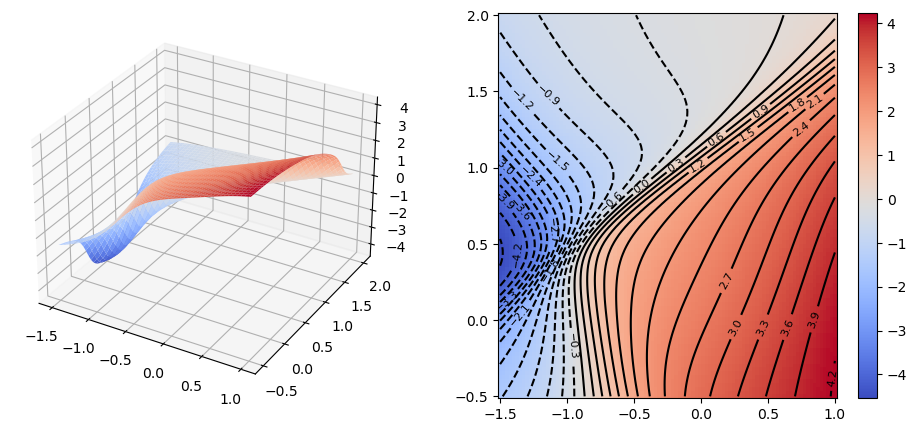

In [20]:
train_autoencoder = True

args = MyArgs(pot_name, train_autoencoder)

# path to store log data
model_path = os.path.join('checkpoint', f"{pot_name}-autoencoder-" + time.strftime("%Y-%m-%d-%H:%M:%S", time.localtime()))
print ('\nLog directory: {}\n'.format(model_path))
        
train_obj = AutoEncoderTask(args, trajectory, model_path)
    
# train autoencoder
train_obj.train()

# print colvar
colvar = train_obj.colvar_model()
plot_cv(colvar)

### Train eigenfunction


shape of trajectory data array:
 torch.Size([10001, 2])

Eigenfunctions:
 EigenFunction(
  (eigen_funcs): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): Tanh()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): Tanh()
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): Tanh()
      (6): Linear(in_features=20, out_features=1, bias=True)
    )
  )
)
Training result will be saved in: checkpoint/MuellerPotential-eigenfunctions-2022-10-05-22:54:27.
View it in tensorboard!

torch.Size([2001, 2])

training starts, 200 epochs in total.
Train set:
	8000 data, 8 iterations per epoch, 1600 iterations in total.
Test set:
	2000 data, 2 iterations per epoch, 400 iterations in total.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:43<00:00,  1.93it/s]


training ends.



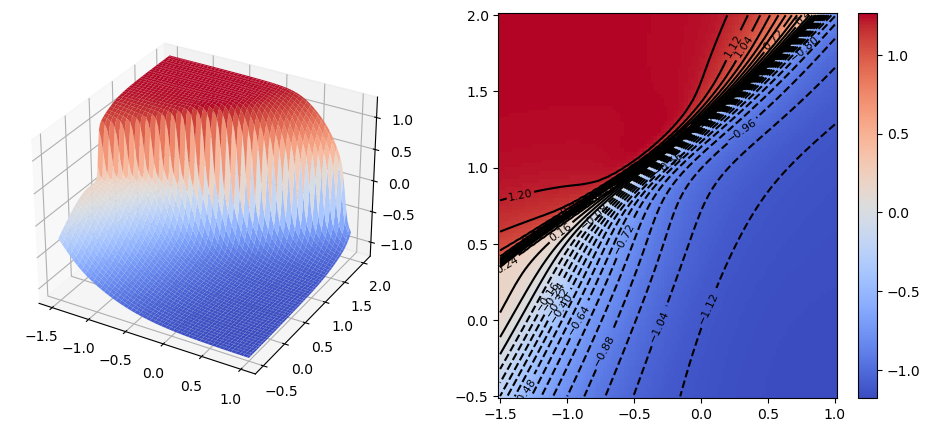

In [21]:
train_autoencoder = False

args = MyArgs(pot_name, train_autoencoder)

model_path = os.path.join('checkpoint', f"{pot_name}-eigenfunctions-" + time.strftime("%Y-%m-%d-%H:%M:%S", time.localtime()))
        
train_obj = EigenFunctionTask(args, trajectory, model_path)
    
train_obj.train()

colvar = train_obj.colvar_model()
plot_cv(colvar)

### Train Autoencoder with gradient regularization



Log directory: checkpoint/MuellerPotential-autoencoder-2022-10-05-22:59:11


shape of trajectory data array:
 torch.Size([10001, 2])

Autoencoder: input dim: 2, encoded dim: 1
 AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=2, bias=True)
  )
)
Training result will be saved in: checkpoint/MuellerPotential-autoencoder-2022-10-05-22:59:11.
View it in tensorboard!


training starts, 200 epochs in total.
8 iterations per epoch, 1600 iterations in total.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:22<00:00,  2.42it/s]


training ends.



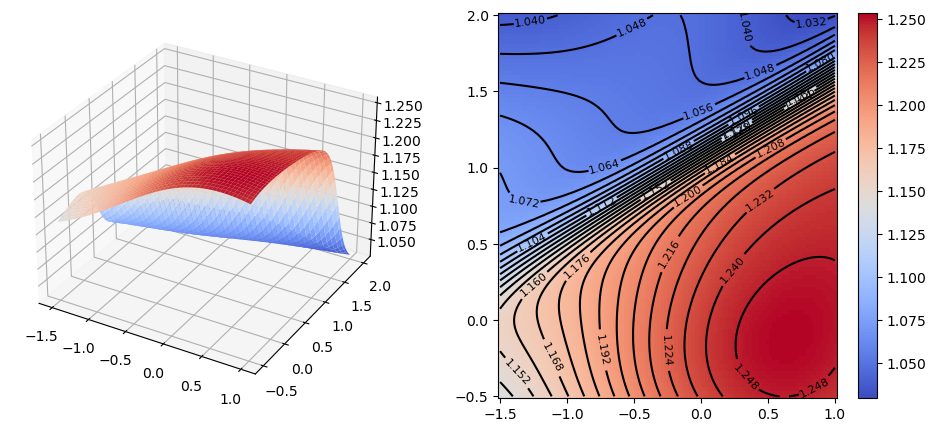

In [23]:
train_autoencoder = True

args = MyArgs(pot_name, train_autoencoder)
args.alpha = 0.1

# path to store log data
model_path = os.path.join('checkpoint', f"{pot_name}-autoencoder-" + time.strftime("%Y-%m-%d-%H:%M:%S", time.localtime()))
print ('\nLog directory: {}\n'.format(model_path))
        
train_obj = AutoEncoderTask(args, trajectory, model_path)
    
# train autoencoder
train_obj.train()

# print colvar
colvar = train_obj.colvar_model()
plot_cv(colvar)